In [1]:
import numpy as np
import matplotlib.pyplot as plt
from inktime import rgbkm
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

from scipy.interpolate import splprep, splev
from scipy.optimize import minimize


### Functions

In [3]:
def RGB_histogram(img, bins = 32, count = False):
    rgb = img.reshape(-1, 3)

    if rgb.max() > 1:
        rgb = rgb / 255.0
    
    hist, edges = np.histogramdd(rgb, bins=(bins, bins, bins), range=((0,1),(0,1),(0,1)))
    
    # Bin centers
    centers = [0.5 * (e[:-1] + e[1:]) for e in edges]
    R, G, B = np.meshgrid(*centers, indexing='ij')
    
    # Flatten
    R = R.ravel()
    G = G.ravel()
    B = B.ravel()
    counts = hist.ravel()
    
    mask = counts > 0
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    if count == True:
        ax.scatter(R[mask], G[mask], B[mask], c =np.stack([R[mask], G[mask], B[mask]], axis=1), s = counts[mask], alpha=0.6)
    elif count == False:
        ax.scatter(R[mask], G[mask], B[mask], c =np.stack([R[mask], G[mask], B[mask]], axis=1), alpha=0.6)
    ax.set_xlabel("R")
    ax.set_ylabel("G")
    ax.set_zlabel("B")

    return fig, ax

### Load in image

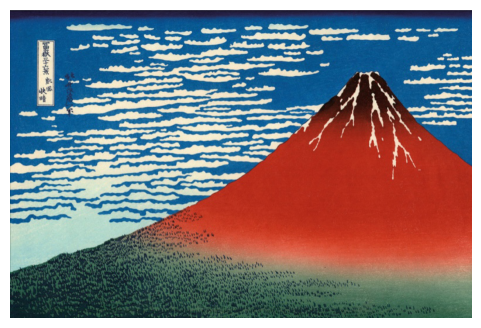

In [7]:
# Load in Red Fuji
img = Image.open("red_fuji.jpg") # Shape (x,y,RGB)
img = np.array(img)/255.0

height, width, _ = img.shape

# Plot
fig, ax = plt.subplots(1, figsize = (12,4))
ax.imshow(img)
ax.axis('off')
plt.show()

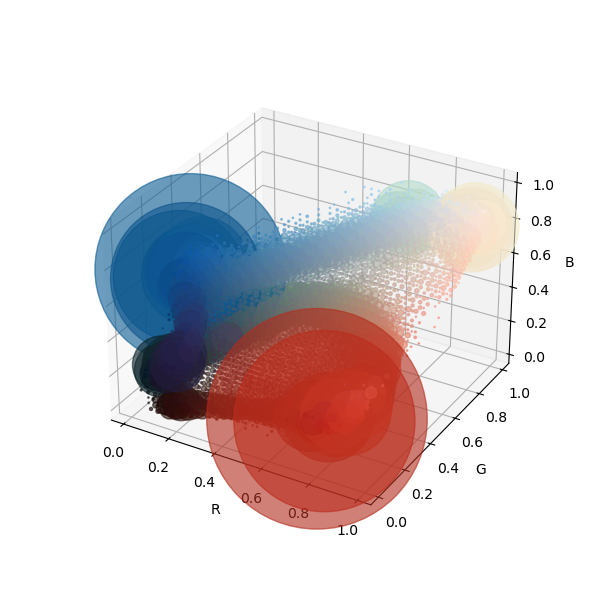

In [9]:
%matplotlib widget
fig, ax = RGB_histogram(img, count = True)
plt.show()

### Kaartje maken

From inktime

Parameters for reflectance function (rgbkm.reflectance):

- K: tuple-like (n channels): Colorant absorption coefficients for wavelength or RGB channels
- S: tuple-like (n channels): Colorant scattering coefficients for wavelength or RGB channels
- D: array ( height x width): Colorant thickness image
- Rg: array (height x width x n) or rgb tuple with shape (3,): Background reflectance image or background color
  
Returns:
- refl: array (height x width x n)
- n-channel reflectance image

In [11]:
%matplotlib inline

R_inf from Kubelka-Munk: [0.55198152 0.00684964 0.0053005 ]


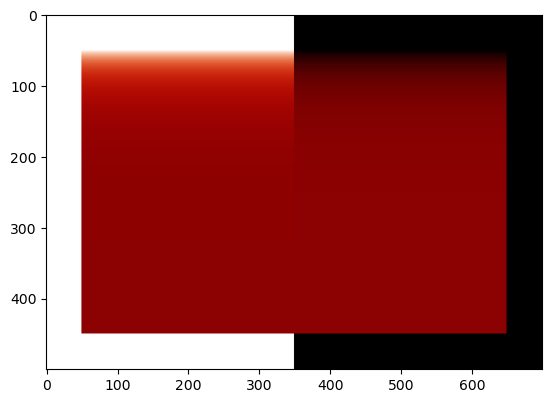

In [250]:
# Black and white background
height, width = 500, 700

Rg = np.ones((height, width, 3))
Rg[:, width // 2:, :] = 0

# Cadmium red (Curtis)
K = np.array([0.14, 1.08, 1.68]) # R, G, B
S = np.array([0.77, 0.015, 0.018])

# Calculate R_inf
a = (K + S) / S
b = np.sqrt(a**2 - 1)
R_inf_true = a - b
print('R_inf from Kubelka-Munk:', R_inf_true)

# Thickness map
border = 50

D_max = 10

D_w = width - 2 * border  # 600
D_h = height - 2 * border  # 400

D_line = np.linspace(0, D_max, D_h)[:, None]      # (400, 1)
D = np.repeat(D_line, D_w, axis=1)  # (400, 600)

D_full = np.zeros((height, width))
D_full[border:border + D_h, border:border + D_w] = D

kaartje = rgbkm.reflectance(K,S,D_full,Rg)


fig, ax = plt.subplots(1)
ax.imshow(kaartje)
plt.show()

R_inf from Kubelka-Munk: [0.55198152 0.00684964 0.0053005 ]


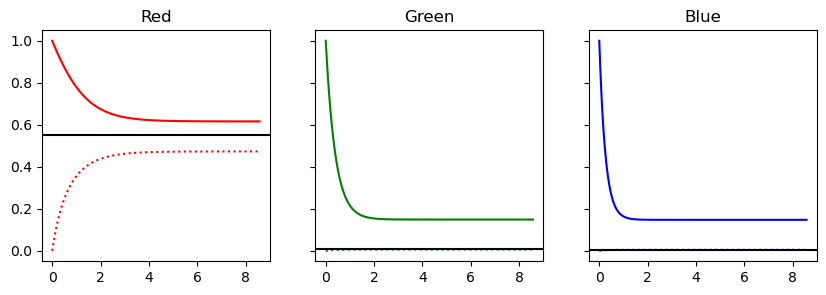

In [252]:
%matplotlib inline

rows = slice(border, border + D_h)
cols_black = slice(width//2, width)
cols_white = slice(0, width//2)

D_black = D_full[rows, cols_black]
D_white = D_full[rows, cols_white]
R_black = kaartje[rows, cols_black, :]
R_white = kaartje[rows, cols_white, :]

print('R_inf from Kubelka-Munk:', R_inf_true)
fig, ax = plt.subplots(1,3, figsize = (10,3), sharey = True)
ax[0].set_title(r'Red')
ax[0].plot(D_white.mean(axis=1), R_white[:,:,0].mean(axis=1), color = 'red')
ax[0].plot(D_black.mean(axis=1), R_black[:,:,0].mean(axis=1), color = 'red', linestyle = 'dotted')
ax[0].axhline(R_inf_true[0], 0, width, color = 'k')
    
ax[1].set_title(r'Green')
ax[1].plot(D_white.mean(axis=1), R_white[:,:,1].mean(axis=1), color = 'green')
ax[1].plot(D_black.mean(axis=1), R_black[:,:,1].mean(axis=1), color = 'green', linestyle = 'dotted')
ax[1].axhline(R_inf_true[1], 0, width, color = 'k')

ax[2].set_title(r'Blue')
ax[2].plot(D_white.mean(axis=1), R_white[:,:,2].mean(axis=1), color = 'blue')
ax[2].plot(D_black.mean(axis=1), R_black[:,:,2].mean(axis=1), color = 'blue', linestyle = 'dotted')
ax[2].axhline(R_inf_true[2], 0, width, color = 'k')


plt.show()

/var/folders/lp/3zzk27qn5z7f87tfqm9gpmlm0000gn/T/ipykernel_31366/3305655325.py:4: RuntimeWarning: divide by zero encountered in divide
  return (1 - Rg*(a - b/np.tanh(b*S*D))) / (a - Rg + b/np.tanh(b*S*D))
/var/folders/lp/3zzk27qn5z7f87tfqm9gpmlm0000gn/T/ipykernel_31366/3305655325.py:4: RuntimeWarning: invalid value encountered in multiply
  return (1 - Rg*(a - b/np.tanh(b*S*D))) / (a - Rg + b/np.tanh(b*S*D))
/var/folders/lp/3zzk27qn5z7f87tfqm9gpmlm0000gn/T/ipykernel_31366/3305655325.py:4: RuntimeWarning: invalid value encountered in divide
  return (1 - Rg*(a - b/np.tanh(b*S*D))) / (a - Rg + b/np.tanh(b*S*D))


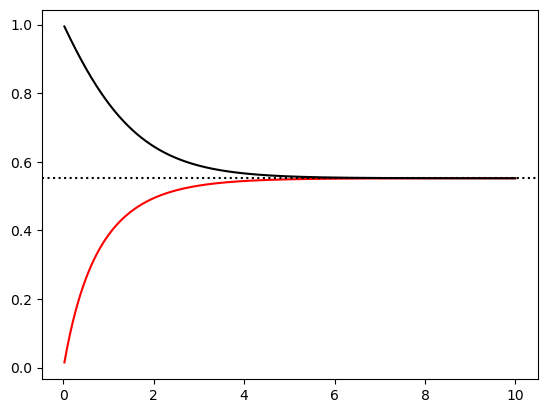

In [242]:
def R_KM_scalar(K, S, D, Rg):
    a = (K + S) / S
    b = np.sqrt(a*a - 1)
    return (1 - Rg*(a - b/np.tanh(b*S*D))) / (a - Rg + b/np.tanh(b*S*D))

D = np.linspace(0, 10, 500)
plt.plot(D, R_KM_scalar(K[0], S[0], D, 0), color = 'red')
plt.plot(D, R_KM_scalar(K[0], S[0], D, 1), color = 'k')
plt.axhline(R_inf_true[0], color = 'k', ls = 'dotted')
plt.show()

### K,S,D terug uit het kaartje halen

In [17]:
def rgb_skeleton(img, N_skel=100):
    """
    Reduce RGB image to a 1D skeleton along the main KM trajectory.
    Returns RGB points along the curve (N_skel,3)
    """
    # Flatten image
    rgb = img.reshape(-1,3)

    # Compute PCA to project onto dominant curve
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=1)
    t = pca.fit_transform(rgb).ravel()  # projection along principal axis

    # Bin along the principal direction
    bins = np.linspace(t.min(), t.max(), N_skel +1)
    inds = np.digitize(t, bins)

    skeleton = []

    for i in range(1, N_skel+1):
        pts = rgb[inds == i]
        if len(pts) > 10:
            skeleton.append(pts.mean(axis = 0))

    return np.array(skeleton)

In [19]:
def thickness_spline(t_skel, coeffs, degree=3):
    """
    Compute thickness D along skeleton given spline coefficients.
    """
    # t_skel: normalized position 0-1
    # coeffs: M control points
    from scipy.interpolate import CubicSpline
    M = len(coeffs)
    t_ctrl = np.linspace(0,1,M)
    spline = CubicSpline(t_ctrl, coeffs, bc_type='natural')
    return spline(t_skel)


In [21]:
def km_curve_loss(theta, rgb_skel, t_skel, Rg_skel, M=10, lambda_smooth=0.01):
    """
    theta = [K_r,K_g,K_b, S_r,S_g,S_b, spline_coeffs...]
    """
    K = theta[:3]
    S = theta[3:6]
    coeffs = theta[6:]
    
    # Thickness along skeleton
    D = thickness_spline(t_skel, coeffs)
    
    # KM predicted RGB
    R_pred = rgbkm.reflectance(K, S, D, Rg_skel)
    
    # Data fidelity
    loss = np.mean((R_pred - rgb_skel)**2)
    
    # Smoothness regularization on spline coefficients
    loss += lambda_smooth * np.mean(np.diff(coeffs,2)**2)  # second derivative
    
    return loss


#### Skeletonize

In [24]:
%matplotlib widget

In [26]:
N_skel = 500

skeleton = rgb_skeleton(kaartje)

#### Using anisotrophy

[0.66054858 0.02548426 0.00739719]


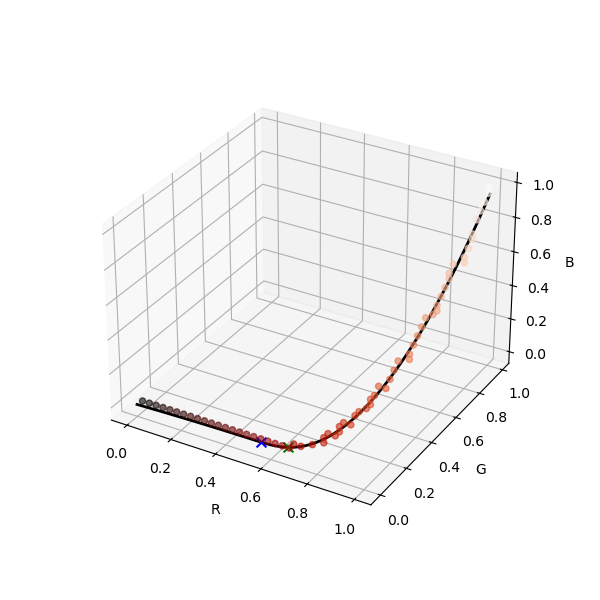

In [29]:
N_skel = 500

skeleton = rgb_skeleton(kaartje)

from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 15
nbrs = NearestNeighbors(n_neighbors=k).fit(skeleton)
_, idxs = nbrs.kneighbors(skeleton)

anisotropy = np.zeros(len(skeleton))

for i, inds in enumerate(idxs):
    P = skeleton[inds]
    C = np.cov(P.T)
    w = np.linalg.eigvalsh(C)
    anisotropy[i] = np.log(w[-1] / (w[-2] + 1e-8))

idx = np.argmin(anisotropy)
R_inf = skeleton[idx]
print(R_inf)

fig, ax = RGB_histogram(kaartje, count = False)
ax.plot(skeleton[:, 0], skeleton[:, 1], skeleton[:, 2], color='black', linewidth=2)
ax.scatter(R_inf[0], R_inf[1], R_inf[2], color = 'g', marker = 'x', s = 50)
ax.scatter(R_inf_true[0], R_inf_true[1], R_inf_true[2], color = 'b', marker = 'x', s = 50)

plt.show()

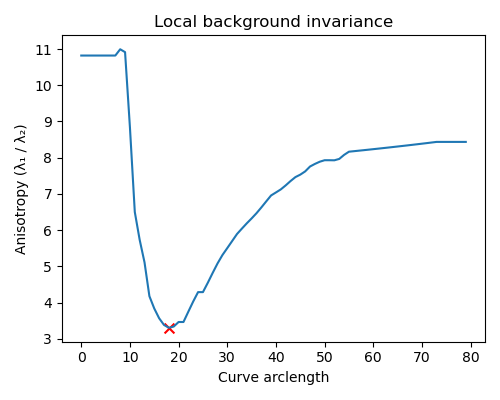

In [31]:
plt.figure(figsize=(5,4))
plt.plot(anisotropy)
plt.scatter(idx, anisotropy[idx], color = 'r', s = 50, marker= 'x')
plt.xlabel("Curve arclength")
plt.ylabel("Anisotropy (λ₁ / λ₂)")
plt.title("Local background invariance")
plt.tight_layout()
plt.show()

#### Using exponentials

In [33]:
R0 = R_inf  #skeleton.mean(axis=0)  # initial guess

v = skeleton - R0
sign = np.sign(np.sum(v, axis=1))  # projection sign > 0 white, < 0 black


In [35]:
def arclength_param(P):
    d = np.linalg.norm(np.diff(P, axis=0), axis=1)
    return np.concatenate([[0], np.cumsum(d)])

Pw = skeleton[sign > 0]
Pb = skeleton[sign < 0]

Dw = arclength_param(Pw)
Db = arclength_param(Pb)


In [37]:
from scipy.optimize import least_squares

def residual(theta, Dw, Db, Rw, Rb):
    Rinf, A, b = theta
    rw = Rinf + A*np.exp(-b*Dw) - Rw
    rb = Rinf - A*np.exp(-b*Db) - Rb
    return np.concatenate([rw, rb])

c = 0  # R channel
theta0 = [0.5, 0.5, 1.0]

res = least_squares(
    residual, theta0,
    args=(Dw, Db, Pw[:,c], Pb[:,c]),
    bounds=([0,0,0],[1,1,10])
)

Rinf_c, A_c, b_c = res.x

print(Rinf_c, A_c, b_c)


0.6064034422540662 0.27633857583354604 3.9912060411101935e-15


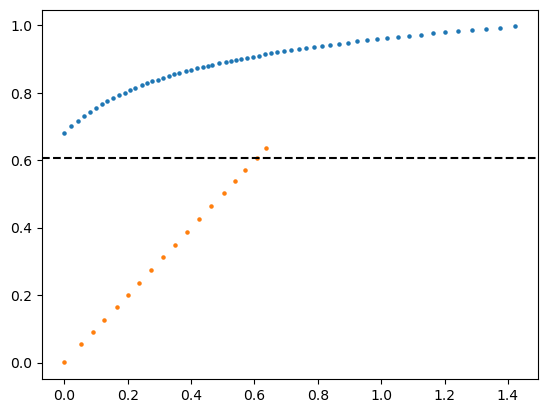

In [65]:
plt.figure()
plt.scatter(Dw, Pw[:,c], s=5)
plt.scatter(Db, Pb[:,c], s=5)
D = np.linspace(0, max(Dw.max(), Db.max()), 200)
#plt.plot(D, Rinf_c + A_c*np.exp(-b_c*D))
#plt.plot(D, Rinf_c - A_c*np.exp(-b_c*D))
plt.axhline(Rinf_c, color='k', linestyle='--')
plt.show()